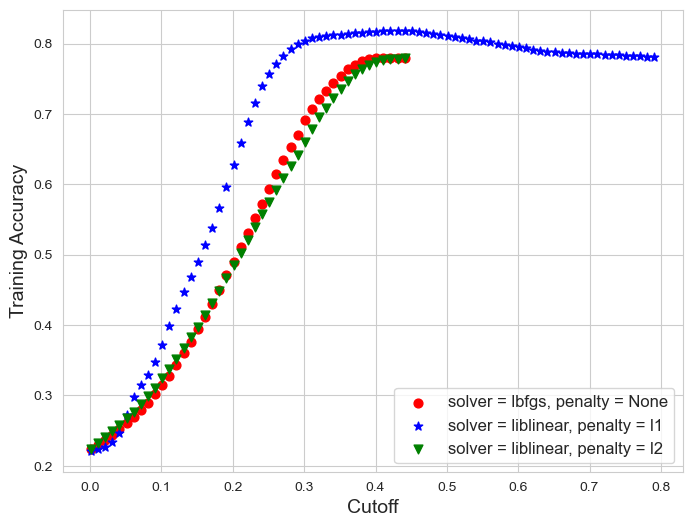

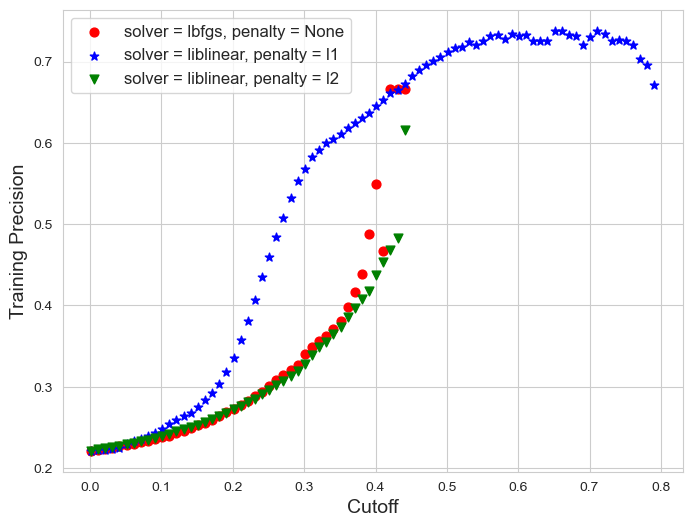

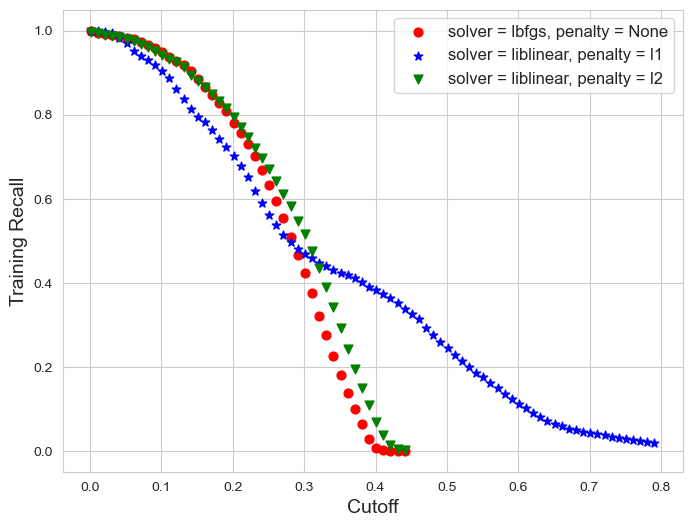

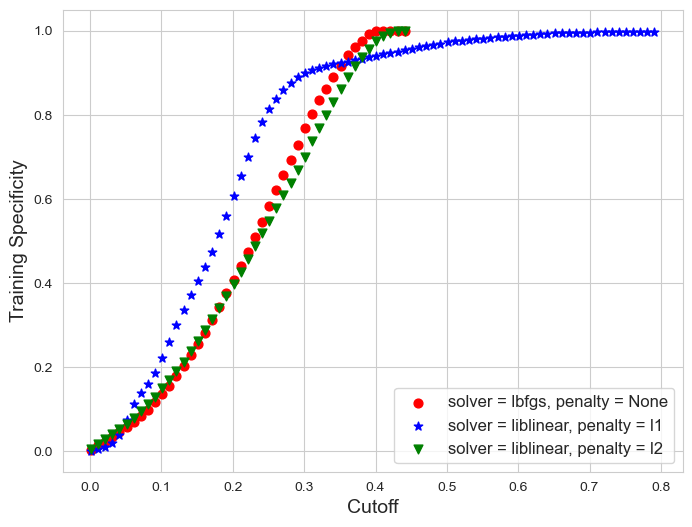

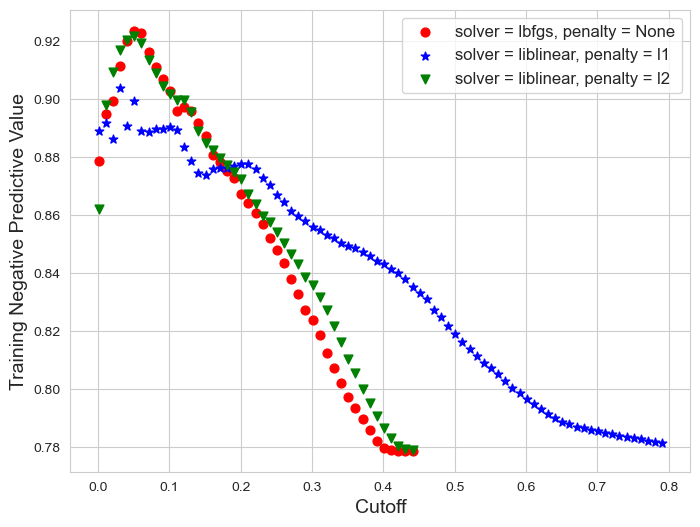

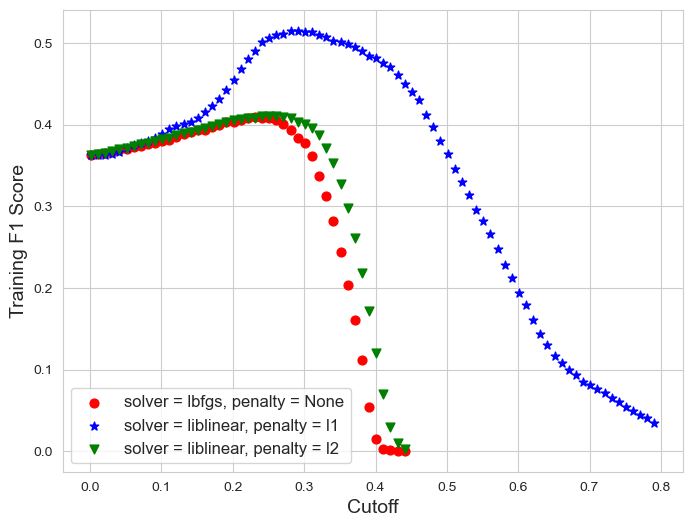

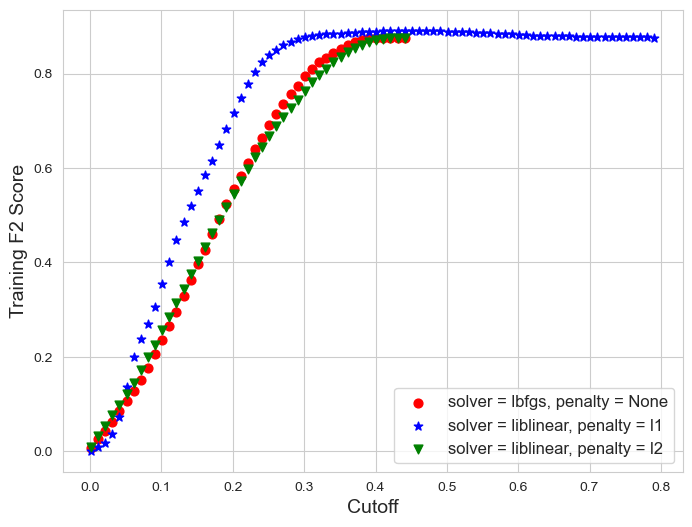

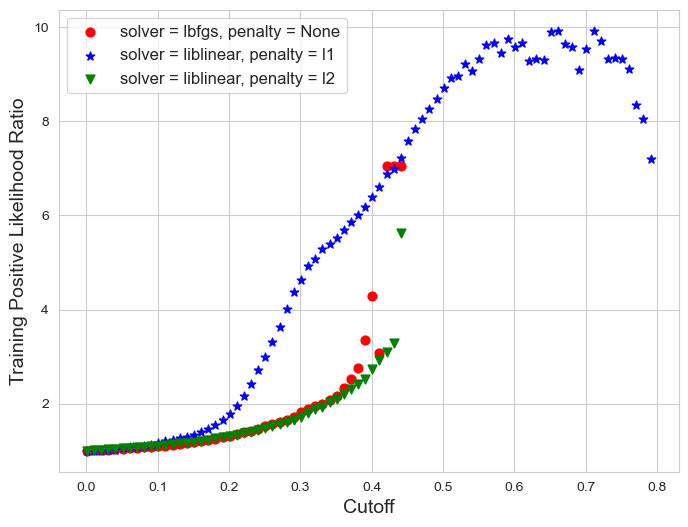

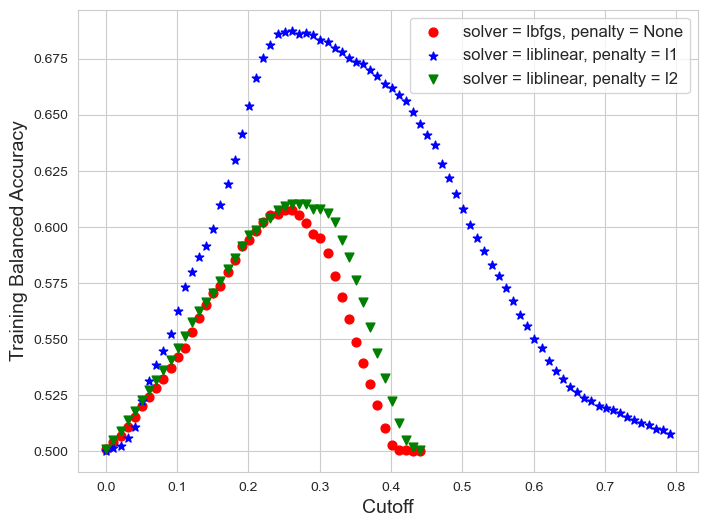

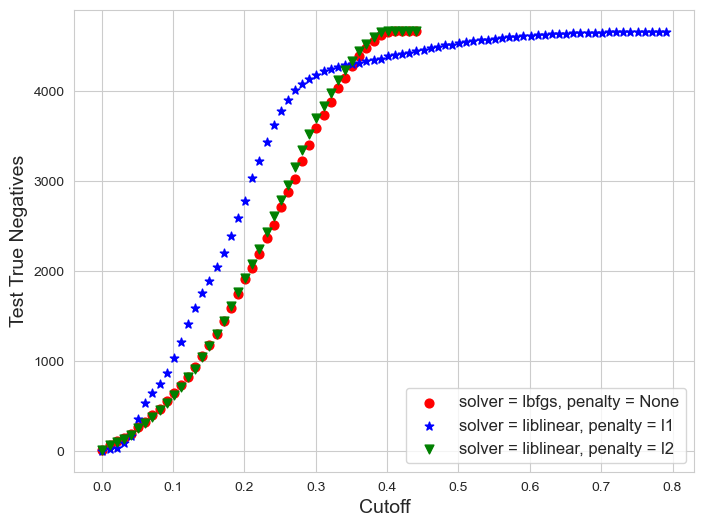

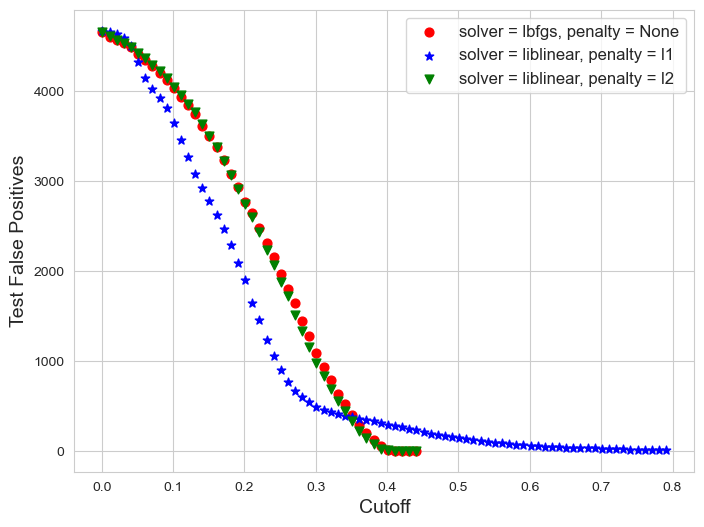

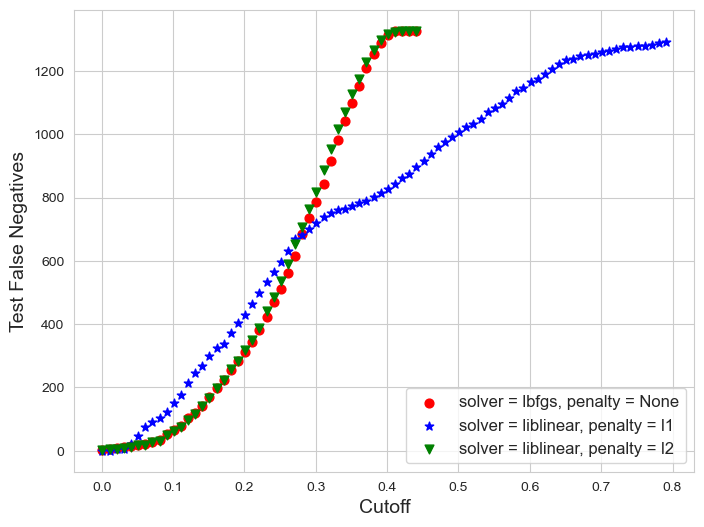

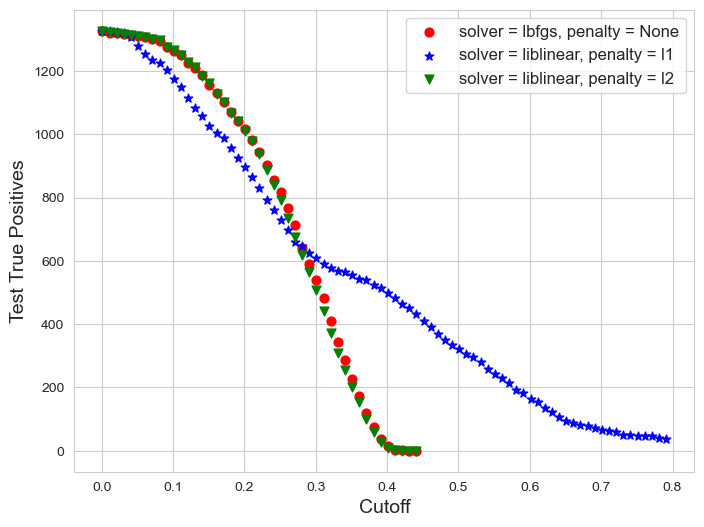

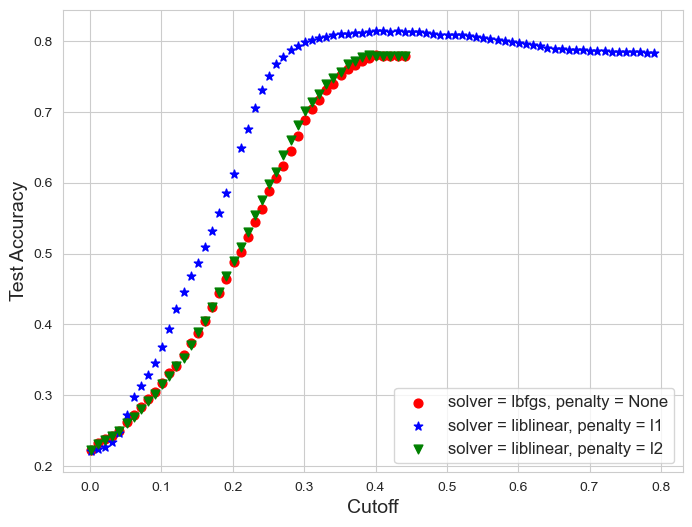

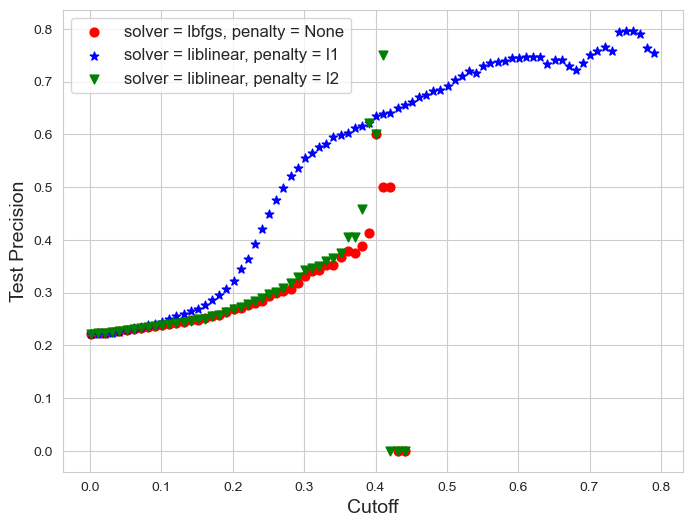

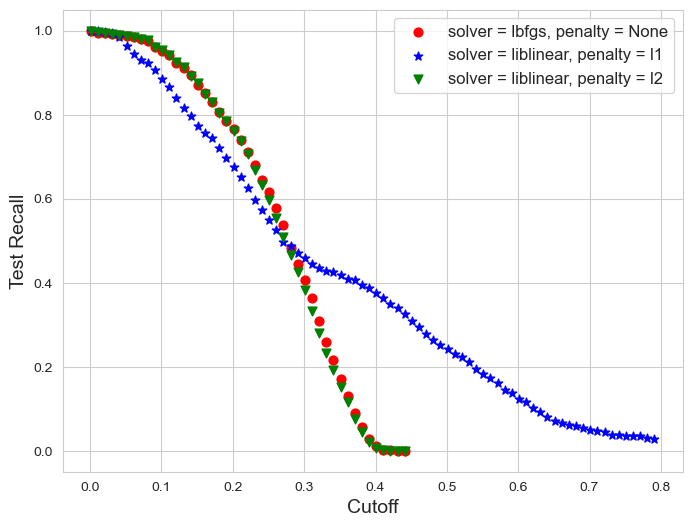

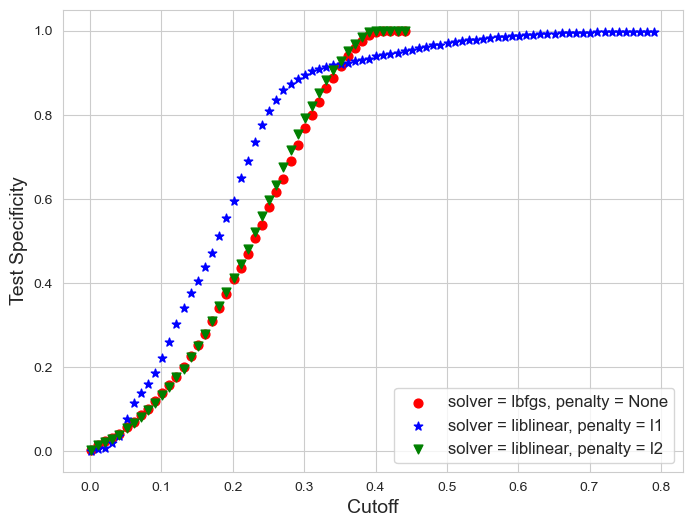

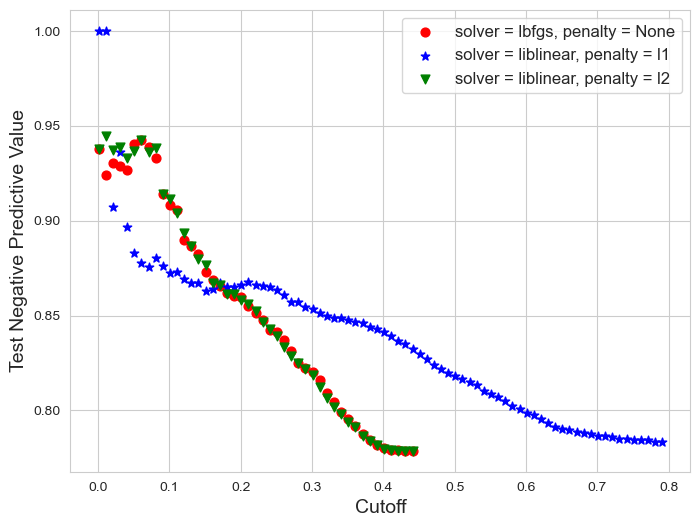

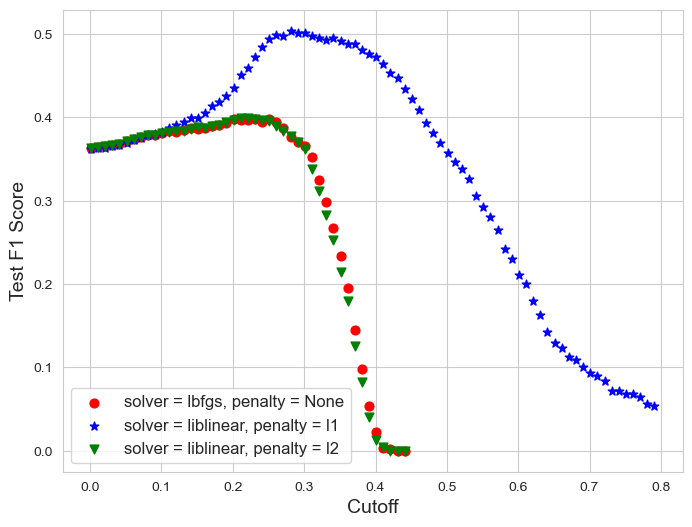

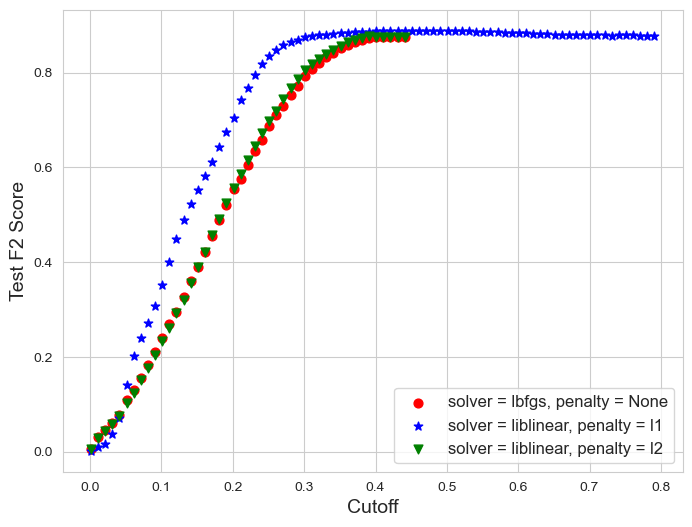

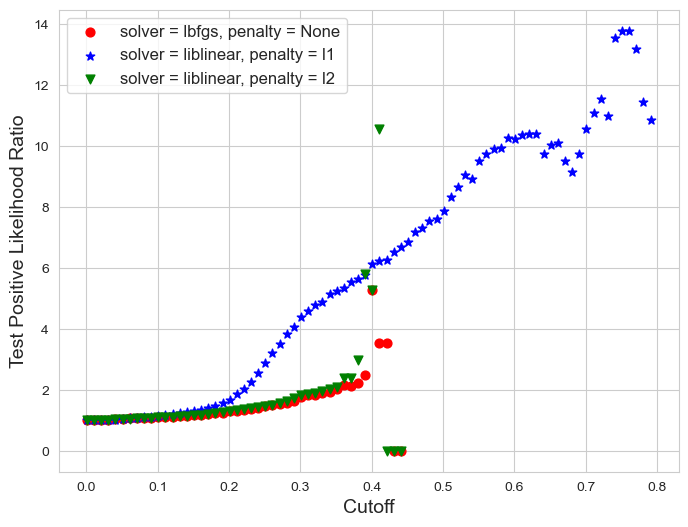

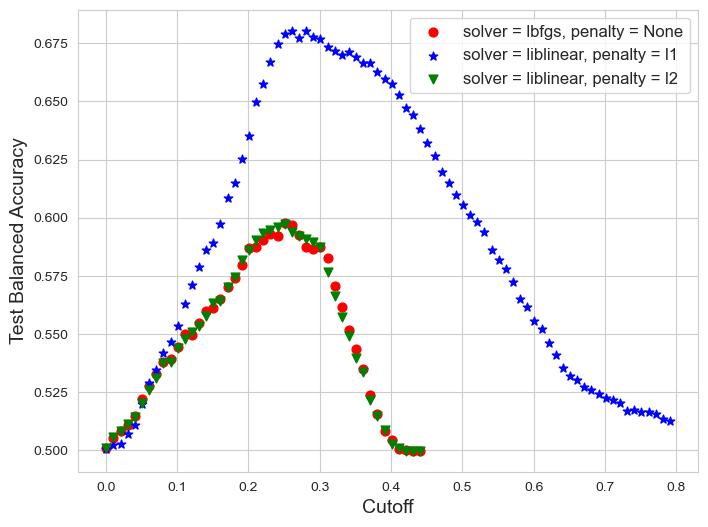

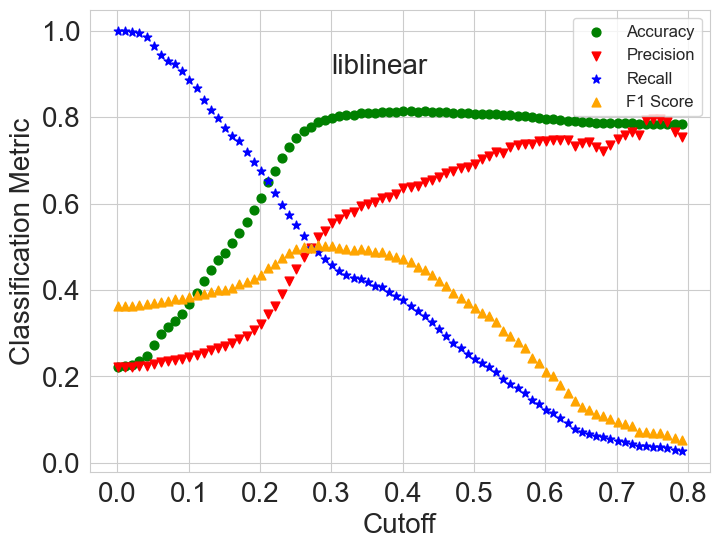

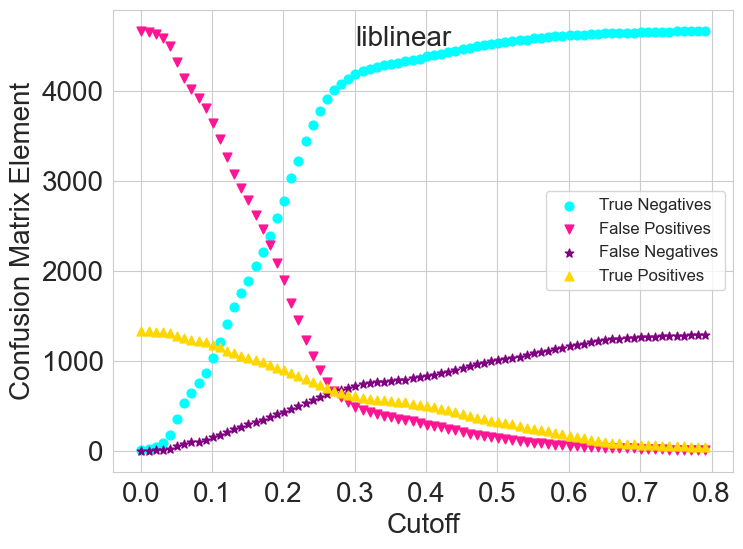

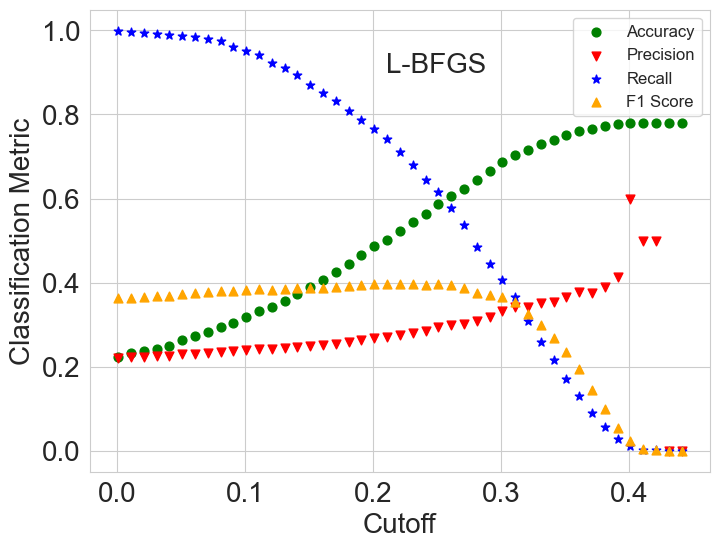

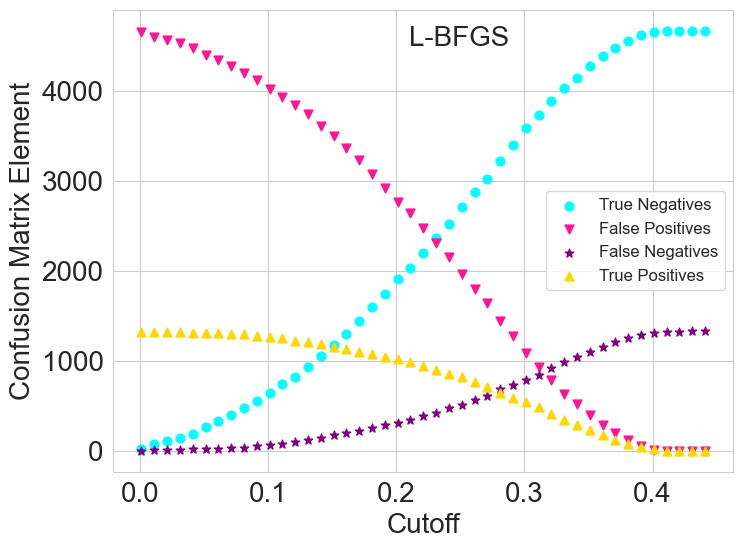

In [1]:
# Author: Alex Lee Melendez
# Last Edited: December 1st, 2023

# Performs classification using scikit learn's LogisticRegression():

# Documentation for LogisticRegression() can be found here:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# Training set data_train is divided into k = 5 splits.
# Regression is performed on the kth training set of data_train,
#     and fit is used to predict outcomes of kth validation set.
# The predictions are compared the real outcomes and the 2x2 confusion
#     matrix is found for a range of cutoff values.
# The arithmetic mean of the matrix elements over the k sets is taken
#     and used to calculate classification metrics such as accuracy,
#     precision, recall and F1 Score.
# Different parameters are varied in LogisticRegression() as well,
#     such as "solver" and "penalty".
# The values of these metrics are plotted as a function of the 
#     decision cutoff, where a "positive" outcome of 1 means default,
#     and a "negative" outcome of 0 is non-default.


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


# import data
df = pd.read_excel(r"C:\\Users\Alex\Documents\GitHub\Responsible Lenders - ALM\default of credit card clients.xls", header=1)

# clean data
data = df.drop(["ID"],axis=1).rename(columns={"PAY_0":"PAY_1","default payment next month":"DEFAULT"}).replace({"EDUCATION":{0:4,5:4,6:4},"MARRIAGE":{0:3}})

# show data
data

# make an 80%-20% stratified train-test split to account for class-imbalance in DEFAULT
data_train, data_test = train_test_split(data.copy(),
                                         shuffle = True,
                                         random_state = 42,
                                         test_size = 0.2,
                                         stratify = data["DEFAULT"])

# initialize stratified k-fold split with k = 5 splits
kfold = StratifiedKFold(n_splits = 5,
                        shuffle = True,
                        random_state = 42)


###########################################
#############  PARAMETERS  ################
###########################################


# parameters passed to LogisticRegression()
LR = [
       {
        "penalty"      : None,
        "tol"          : 1e-4,
        "class_weight" : None,
        "solver"       : "lbfgs",
        "max_iter"     : 1000,
        "cutoff_min"   : 0.001,
        "cutoff_max"   : 0.45,
        "cutoff_step"  : 0.01,
        "color"        : "red",
        "marker"       : "o",
        "size"         : 40
       },
       {
        "penalty"      : "l1",
        "tol"          : 1e-4,
        "class_weight" : None,
        "solver"       : "liblinear",
        "max_iter"     : 1000,
        "cutoff_min"   : 0.001,
        "cutoff_max"   : 0.8,
        "cutoff_step"  : 0.01,
        "color"        : "blue",
        "marker"       : "*",
        "size"         : 40
       },
       {
        "penalty"      : "l2",
        "tol"          : 1e-4,
        "class_weight" : None,
        "solver"       : "liblinear",
        "max_iter"     : 1000,
        "cutoff_min"   : 0.001,
        "cutoff_max"   : 0.45,
        "cutoff_step"  : 0.01,
        "color"        : "green",
        "marker"       : "v",
        "size"         : 40
       },
      ]

# classification metrics to calculate
metrics = ["Accuracy",
           "Precision",
           "Recall",
           "Specificity",
           "Negative Predictive Value",
           "F1 Score",
           "F2 Score",
           "Positive Likelihood Ratio",
           "Balanced Accuracy"
          ]

# plotting parameters
fig_x = 8    # plot x size
fig_y = 6    # plot y size
x_font = 14    # x-label font size
y_font = 14    # y-label font size
leg_font = 12    # legend font size


###########################################
#############  CALCULATION  ###############
###########################################


#########################
# k-fold cross validation
#########################

# loop through parameter sets in LR
for lr in LR:
    # initialize LogisticRegression with passed parameters
    log_reg = LogisticRegression(penalty=lr["penalty"],tol=lr["tol"],solver=lr["solver"],max_iter=lr["max_iter"])
    
    # define cutoff range and initialize arrays for confusion matrix elements
    lr["cutoffs"] = np.arange(lr["cutoff_min"],lr["cutoff_max"],lr["cutoff_step"])
    lr["avg_TN"] = np.zeros(shape=len(lr["cutoffs"]))
    lr["avg_FP"] = np.zeros(shape=len(lr["cutoffs"]))
    lr["avg_FN"] = np.zeros(shape=len(lr["cutoffs"]))
    lr["avg_TP"] = np.zeros(shape=len(lr["cutoffs"]))
    
    # loop through k-fold splits to take the average of the fits
    k = 0
    for train_index, test_index in kfold.split(data_train.drop(["DEFAULT"],axis=1),data_train.DEFAULT):
        # fit LogisticRegression to the kth split
        log_reg.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
        # predict outcomes of kth validation set
        y_train_prob = log_reg.predict_proba(data_train.iloc[test_index].drop(["DEFAULT"],axis=1))[:,1]
        
        TN = []    # true negatives
        FP = []    # false positives
        FN = []    # false negatives
        TP = []    # true positives
        
        # loop through cutoff values
        for cutoff in lr["cutoffs"]:
            # determine if value is above or below cutoff, returning 1 or 0 respectively
            y_train_pred = 1*(y_train_prob >= cutoff)
            
                        # calculate elements of confusion matrix for each cutoff value
            TN.append(confusion_matrix(data_train.iloc[test_index].DEFAULT,y_train_pred).ravel()[0])
            FP.append(confusion_matrix(data_train.iloc[test_index].DEFAULT,y_train_pred).ravel()[1])
            FN.append(confusion_matrix(data_train.iloc[test_index].DEFAULT,y_train_pred).ravel()[2])
            TP.append(confusion_matrix(data_train.iloc[test_index].DEFAULT,y_train_pred).ravel()[3])
        
        # sum elements of confusion matrix k times
        lr["avg_TN"] += TN
        lr["avg_FP"] += FP
        lr["avg_FN"] += FN
        lr["avg_TP"] += TP
        
        k = k + 1
        
    # divide by k to calculate average of confusion matrix elements
    lr["avg_TN"] /= k
    lr["avg_FP"] /= k
    lr["avg_FN"] /= k
    lr["avg_TP"] /= k
    
    # calculations of metrics
    # accuracy = (TP + TN)/(TP + TN + FP + FN)
    lr[metrics[0]] = (lr["avg_TP"]+lr["avg_TN"])/(lr["avg_TP"]+lr["avg_TN"]+lr["avg_FP"]+lr["avg_FN"])
    # precision (PPV) = TP/(TP + FP)
    lr[metrics[1]] = (lr["avg_TP"])/(lr["avg_TP"]+lr["avg_FP"])
    # recall (TPR) = TP/(TP + FN)
    lr[metrics[2]] = (lr["avg_TP"])/(lr["avg_TP"]+lr["avg_FN"])
    # specificity (TNR) = TN/(TN + FP)
    lr[metrics[3]] = (lr["avg_TN"]/(lr["avg_TN"]+lr["avg_FP"]))
    # negative predictive value (NPV) = TN/(TN + FN)
    lr[metrics[4]] = (lr["avg_TN"])/(lr["avg_TN"]+lr["avg_FN"])
    # harmonic mean of PPV and TPR:  F1 = 2 * (PPV * TPR)/(PPV + TPR)
    lr[metrics[5]] = 2*(lr[metrics[1]]*lr[metrics[2]])/(lr[metrics[1]] + lr[metrics[2]])
    # harmonic mean of NPV and TNR:  F2 = 2 * (NPV * TNR)/(NPV + TNR)
    lr[metrics[6]] = 2*(lr[metrics[3]]*lr[metrics[4]])/(lr[metrics[3]] + lr[metrics[4]])
    # positive likelihood ratio = TPR/(1-TNR)
    lr[metrics[7]] = (lr[metrics[2]])/(1-lr[metrics[3]])
    # balanced accuracy = (TPR + TNR)/2
    lr[metrics[8]] = (lr[metrics[2]]+lr[metrics[3]])/2
    
    
#########################################
#############  PLOTTING  ################
#########################################

# plotting results from k-fold cross-validation

# loop through metrics and plot them
for metric in metrics:
    # initialize plot frame
    plt.figure(figsize=(fig_x,fig_y))

    # loop through parameter sets in LR
    for lr in LR:
        # make scatterplots
        plt.scatter(lr["cutoffs"],    # x data
                    lr[metric],    # y data
                    label = "solver = " + str(lr["solver"]) + ", penalty = " + str(lr["penalty"]),
                    c = lr["color"],    # marker color
                    marker = lr["marker"],    # marker shape
                    s = lr["size"]    # marker size
                   )
    
    # plot labels and legend
    plt.xlabel("Cutoff",fontsize=x_font)
    plt.ylabel("Training "+metric,fontsize=y_font)
    plt.legend(fontsize=leg_font)
    plt.show()
    
    
########################
# Regression on Test Set
########################


# classification metrics to calculate
metrics = ["True Negatives",
           "False Positives",
           "False Negatives",
           "True Positives",
           "Accuracy",
           "Precision",
           "Recall",
           "Specificity",
           "Negative Predictive Value",
           "F1 Score",
           "F2 Score",
           "Positive Likelihood Ratio",
           "Balanced Accuracy"
          ]

# loop through parameter sets in LR
for lr in LR:
    # initialize LogisticRegression with passed parameters
    log_reg = LogisticRegression(penalty=lr["penalty"],tol=lr["tol"],solver=lr["solver"],max_iter=lr["max_iter"])
    
    # define cutoff range and initialize arrays for confusion matrix elements
    lr["cutoffs"] = np.arange(lr["cutoff_min"],lr["cutoff_max"],lr["cutoff_step"])
    
    for metric in metrics:
        lr[metric] = []
    
    # fit entire training set
    log_reg.fit(data_train.drop(["DEFAULT"],axis=1),data_train.DEFAULT)
    
    # predict outcomes of test set
    y_prob = log_reg.predict_proba(data_test.drop(["DEFAULT"],axis=1))[:,1]

    # loop through cutoff values
    for cutoff in lr["cutoffs"]:
        
        # determine if value is above or below cutoff, returning 1 or 0 respectively
        y_test_pred = 1*(y_prob >= cutoff)
        
        # calculate elements of confusion matrix for each cutoff value
        TN = confusion_matrix(data_test.DEFAULT,y_test_pred).ravel()[0]
        FP = confusion_matrix(data_test.DEFAULT,y_test_pred).ravel()[1]
        FN = confusion_matrix(data_test.DEFAULT,y_test_pred).ravel()[2]
        TP = confusion_matrix(data_test.DEFAULT,y_test_pred).ravel()[3]
        
        PPV = TP/(TP + FP)
        TPR = TP/(TP + FN)
        TNR = TN/(TN + FP)
        NPV = TN/(TN + FN)
    
        # calculations of metrics
        # true negative
        lr[metrics[0]].append(TN)
        # false positive
        lr[metrics[1]].append(FP)
        # false negative
        lr[metrics[2]].append(FN)
        # true positive
        lr[metrics[3]].append(TP)
        # accuracy = (TP + TN)/(TP + TN + FP + FN)
        lr[metrics[4]].append((TP+TN)/(TP+TN+FP+FN))
        # precision (PPV) = TP/(TP + FP)
        lr[metrics[5]].append(PPV)
        # recall (TPR) = TP/(TP + FN)
        lr[metrics[6]].append(TPR)
        # specificity (TNR) = TN/(TN + FP)
        lr[metrics[7]].append(TNR)
        # negative predictive value (NPV) = TN/(TN + FN)
        lr[metrics[8]].append(NPV)
        # harmonic mean of PPV and TPR:  F1 = 2 * (PPV * TPR)/(PPV + TPR)
        lr[metrics[9]].append(2*(PPV * TPR)/(PPV + TPR + 1e-16))
        # harmonic mean of NPV and TNR:  F2 = 2 * (NPV * TNR)/(NPV + TNR)
        lr[metrics[10]].append(2*(NPV * TNR)/(NPV + TNR))
        # positive likelihood ratio = TPR/(1-TNR)
        lr[metrics[11]].append(TPR/(1-TNR))
        # balanced accuracy = (TPR + TNR)/2
        lr[metrics[12]].append((TPR + TNR)/2)

        
#########################################
#############  PLOTTING  ################
#########################################

# plotting the results of predicting the test set,
# where each metric gets its own graph

# loop through metrics and plot them
for metric in metrics:
    # initialize plot frame
    plt.figure(figsize=(fig_x,fig_y))

    # loop through parameter sets in LR
    for lr in LR:
        # make scatterplots
        plt.scatter(lr["cutoffs"],    # x data
                    lr[metric],    # y data
                    label = "solver = " + str(lr["solver"]) + ", penalty = " + str(lr["penalty"]),
                    c = lr["color"],    # marker color
                    marker = lr["marker"],    # marker shape
                    s = lr["size"]    # marker size
                   )
    
    # plot labels and legend
    plt.xlabel("Cutoff",fontsize=x_font)
    plt.ylabel("Test "+metric,fontsize=y_font)
    plt.legend(fontsize=leg_font)
    plt.show()
    


#########################################
#############  PLOTTING  ################
#########################################
    
# plot accuracy, precision, recall and F1 Score 
# parameters: "solver" = liblinear and "penalty" = l1

# initialize plot frame
plt.figure(figsize=(fig_x,fig_y))


# make scatterplots
plt.scatter(LR[1]["cutoffs"],    # x data
            LR[1]["Accuracy"],    # y data
            label = "Accuracy",
            c = "green",    # marker color
            marker = "o",    # marker shape
            s = LR[1]["size"]    # marker size
           )
plt.scatter(LR[1]["cutoffs"],    # x data
            LR[1]["Precision"],    # y data
            label = "Precision",
            c = "red",    # marker color
            marker = "v",    # marker shape
            s = LR[1]["size"]    # marker size
           )
plt.scatter(LR[1]["cutoffs"],    # x data
            LR[1]["Recall"],    # y data
            label = "Recall",
            c = "blue",    # marker color
            marker = "*",    # marker shape
            s = LR[1]["size"]    # marker size
           )
plt.scatter(LR[1]["cutoffs"],    # x data
            LR[1]["F1 Score"],    # y data
            label = "F1 Score",
            c = "orange",    # marker color
            marker = "^",    # marker shape
            s = LR[1]["size"]    # marker size
           )

# plot labels and legend
plt.xlabel("Cutoff",fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("Classification Metric",fontsize=20)
plt.yticks(fontsize=20)
plt.text(0.3,0.9,"liblinear",fontsize=20)
plt.legend(fontsize=leg_font)
plt.show()


# plot elements of confusion matrix: (TN, FP, FN, TP)
# parameters: "solver" = liblinear and "penalty" = l1

# initialize plot frame
plt.figure(figsize=(fig_x,fig_y))


# make scatterplots
plt.scatter(LR[1]["cutoffs"],    # x data
            LR[1]["True Negatives"],    # y data
            label = "True Negatives",
            c = "cyan",    # marker color
            marker = "o",    # marker shape
            s = LR[1]["size"]    # marker size
           )
plt.scatter(LR[1]["cutoffs"],    # x data
            LR[1]["False Positives"],    # y data
            label = "False Positives",
            c = "deeppink",    # marker color
            marker = "v",    # marker shape
            s = LR[1]["size"]    # marker size
           )
plt.scatter(LR[1]["cutoffs"],    # x data
            LR[1]["False Negatives"],    # y data
            label = "False Negatives",
            c = "purple",    # marker color
            marker = "*",    # marker shape
            s = LR[1]["size"]    # marker size
           )
plt.scatter(LR[1]["cutoffs"],    # x data
            LR[1]["True Positives"],    # y data
            label = "True Positives",
            c = "gold",    # marker color
            marker = "^",    # marker shape
            s = LR[1]["size"],    # marker size
#             edgecolors = "black"
           )

# plot labels and legend
plt.xlabel("Cutoff",fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("Confusion Matrix Element",fontsize=20)
plt.yticks(fontsize=20)
plt.text(0.3,4500,"liblinear",fontsize=20)
plt.legend(fontsize=leg_font)
plt.show()


# plot accuracy, precision, recall and F1 Score 
# parameters: "solver" = lbfgs and "penalty" = None

# initialize plot frame
plt.figure(figsize=(fig_x,fig_y))


# make scatterplots
plt.scatter(LR[0]["cutoffs"],    # x data
            LR[0]["Accuracy"],    # y data
            label = "Accuracy",
            c = "green",    # marker color
            marker = "o",    # marker shape
            s = LR[0]["size"]    # marker size
           )
plt.scatter(LR[0]["cutoffs"],    # x data
            LR[0]["Precision"],    # y data
            label = "Precision",
            c = "red",    # marker color
            marker = "v",    # marker shape
            s = LR[0]["size"]    # marker size
           )
plt.scatter(LR[0]["cutoffs"],    # x data
            LR[0]["Recall"],    # y data
            label = "Recall",
            c = "blue",    # marker color
            marker = "*",    # marker shape
            s = LR[0]["size"]    # marker size
           )
plt.scatter(LR[0]["cutoffs"],    # x data
            LR[0]["F1 Score"],    # y data
            label = "F1 Score",
            c = "orange",    # marker color
            marker = "^",    # marker shape
            s = LR[0]["size"]    # marker size
           )

# plot labels and legend
plt.xlabel("Cutoff",fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("Classification Metric",fontsize=20)
plt.yticks(fontsize=20)
plt.text(0.21,0.9,"L-BFGS",fontsize=20)
plt.legend(fontsize=leg_font)
plt.show()


# plot elements of confusion matrix: (TN, FP, FN, TP)
# parameters: "solver" = lbfgs and "penalty" = None

# initialize plot frame
plt.figure(figsize=(fig_x,fig_y))

# make scatterplots
plt.scatter(LR[0]["cutoffs"],    # x data
            LR[0]["True Negatives"],    # y data
            label = "True Negatives",
            c = "cyan",    # marker color
            marker = "o",    # marker shape
            s = LR[0]["size"]    # marker size
           )
plt.scatter(LR[0]["cutoffs"],    # x data
            LR[0]["False Positives"],    # y data
            label = "False Positives",
            c = "deeppink",    # marker color
            marker = "v",    # marker shape
            s = LR[0]["size"]    # marker size
           )
plt.scatter(LR[0]["cutoffs"],    # x data
            LR[0]["False Negatives"],    # y data
            label = "False Negatives",
            c = "purple",    # marker color
            marker = "*",    # marker shape
            s = LR[0]["size"]    # marker size
           )
plt.scatter(LR[0]["cutoffs"],    # x data
            LR[0]["True Positives"],    # y data
            label = "True Positives",
            c = "gold",    # marker color
            marker = "^",    # marker shape
            s = LR[0]["size"],    # marker size
#             edgecolors = "black"
           )

# plot labels and legend
plt.xlabel("Cutoff",fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("Confusion Matrix Element",fontsize=20)
plt.yticks(fontsize=20)
plt.text(0.21,4500,"L-BFGS",fontsize=20)
plt.legend(fontsize=leg_font)
plt.show()